In [22]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from matplotlib import pyplot as plt
import cv2
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [24]:
dataset_path = 'C:/Users/user/Downloads/Data settt/Hairdata/hairtypes'

In [25]:
print(dataset_path)

C:/Users/user/Downloads/Data settt/Hairdata/hairtypes


In [26]:
full_dataset = ImageFolder(dataset_path, transform=transforms.Compose([transforms.Resize((128, 128)), transforms.RandomHorizontalFlip(p=0.2),transforms.ToTensor()]))

In [27]:
len(full_dataset)

241

In [28]:
train_dataset, val_dataset = random_split(full_dataset, [141, 100])

In [29]:
batch_size = 90

In [30]:
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=4, pin_memory=True)

In [31]:
print(full_dataset.classes)

['Curly Hair', 'Straight Hair', 'Wavy Hair']


Label : Curly Hair


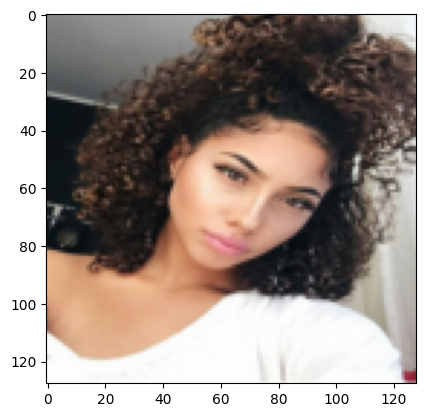

In [32]:
def display_img(img,label):
    print(f"Label : {full_dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*full_dataset[7])

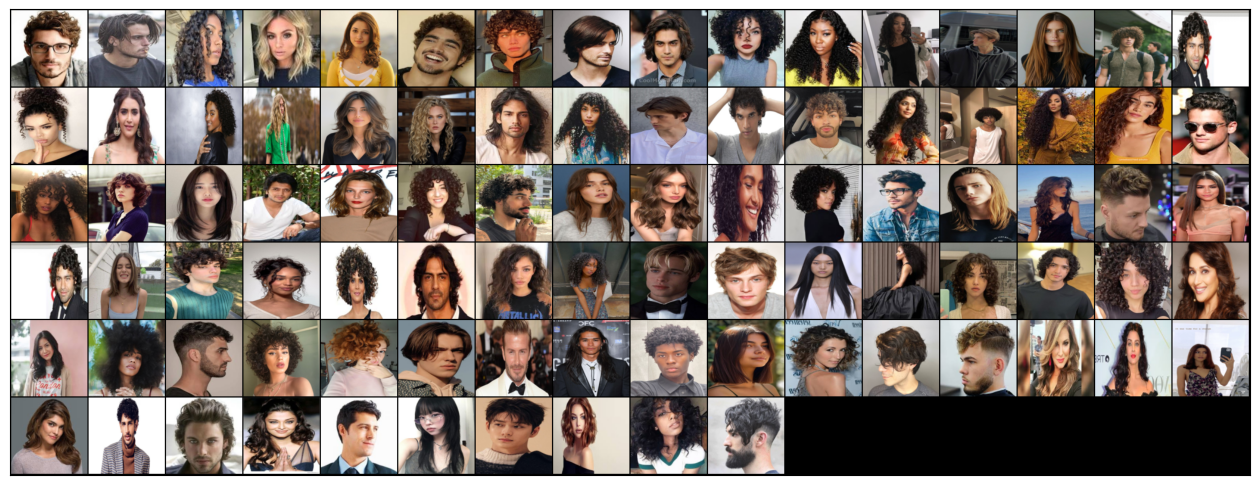

In [33]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

In [36]:
class ImageClassification(nn.Module):

    def train_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)

        return {'val_loss': loss.detach(), 'val_acc': acc}


    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}


    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [35]:
class HairModelClassification(ImageClassification):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
        
            # Layer 1
            nn.Conv2d(3, 32, kernel_size=3, padding=(2, 2), stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=(2, 2), stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.5),
            
            # Layer 2
            nn.Conv2d(64, 128, kernel_size=3, padding=(2,2), stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=(2,2), stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.5),
            
            # layer 3
            nn.Conv2d(128, 128, kernel_size=3, padding=(2,2), stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.5),
            
            # Last layer
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3)            
        )

    def forward(self, xb):
        return self.network(xb)

In [37]:
model = HairModelClassification()

In [38]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):

    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):

        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.train_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [39]:
num_epochs = 130
opt_func = torch.optim.Adam
lr = 0.001
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.0859, val_loss: 1.0890, val_acc: 0.4100
Epoch [1], train_loss: 1.0846, val_loss: 1.0884, val_acc: 0.4100
Epoch [2], train_loss: 1.0765, val_loss: 1.0874, val_acc: 0.3600
Epoch [3], train_loss: 1.0669, val_loss: 1.0943, val_acc: 0.3300
Epoch [4], train_loss: 1.0643, val_loss: 1.1046, val_acc: 0.3300
Epoch [5], train_loss: 1.0697, val_loss: 1.0883, val_acc: 0.3800
Epoch [6], train_loss: 1.0580, val_loss: 1.0833, val_acc: 0.4100
Epoch [7], train_loss: 1.0650, val_loss: 1.0825, val_acc: 0.4100
Epoch [8], train_loss: 1.0616, val_loss: 1.0832, val_acc: 0.4100
Epoch [9], train_loss: 1.0627, val_loss: 1.0825, val_acc: 0.4100
Epoch [10], train_loss: 1.0555, val_loss: 1.0859, val_acc: 0.4100
Epoch [11], train_loss: 1.0664, val_loss: 1.0882, val_acc: 0.4100
Epoch [12], train_loss: 1.0744, val_loss: 1.0864, val_acc: 0.4100
Epoch [13], train_loss: 1.0761, val_loss: 1.0843, val_acc: 0.4100
Epoch [14], train_loss: 1.0623, val_loss: 1.0831, val_acc: 0.4100
Epoch [15], train_lo

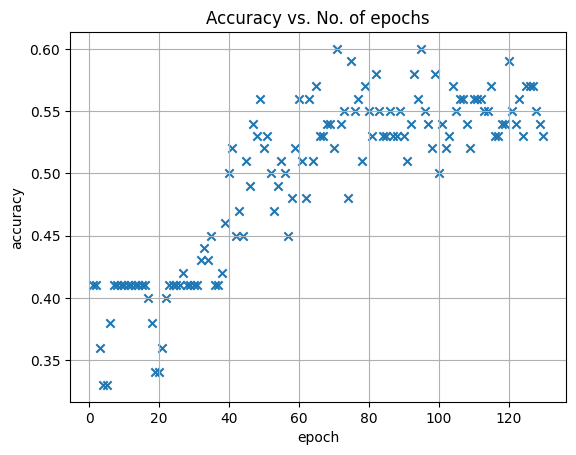

In [40]:
def plot_accuracies(history):
    """ Plot the history of accuracies as a scatter plot"""
    accuracies = [x['val_acc'] for x in history]
    epochs = range(1, len(accuracies) + 1)
    plt.scatter(epochs, accuracies, marker='x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.grid(True)  # Optional: Add grid lines for better readability


plot_accuracies(history)

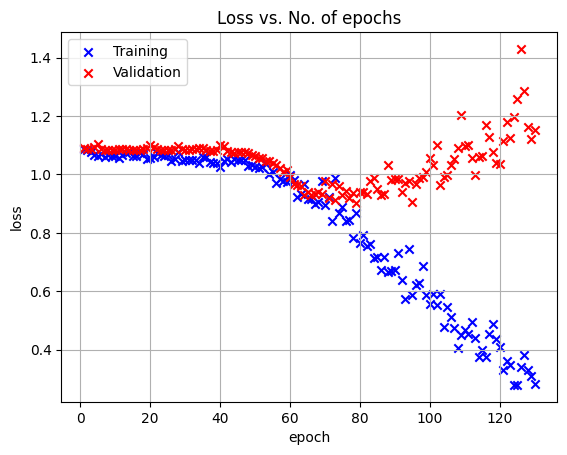

In [41]:
def plot_losses(history):
    """ Plot the losses in each epoch as scatter plots"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    epochs = range(1, len(train_losses) + 1)
    
    plt.scatter(epochs, train_losses, marker='x', color='blue')
    plt.scatter(epochs, val_losses, marker='x', color='red')
    
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.grid(True)  # Optional: Add grid lines for better readability

# Assuming `history` is defined somewhere in your code
plot_losses(history)


In [42]:
import h5py

# Definisikan path untuk menyimpan model
model_path = 'hairtypes_model.h5'

# Save the model state dictionary to a file
torch.save(model.state_dict(), 'hairtypes_model.pth')

# Load the saved model state dictionary
model.load_state_dict(torch.load('hairtypes_model.pth'))
model.eval()

# Save the model to HDF5 format
with h5py.File(model_path, 'w') as f:
    # Create a group to store the model architecture
    f.create_group('model_weights')
    
    # Get model state_dict
    model_state = model.state_dict()
    
    # Save model state_dict to HDF5 format
    for k, v in model_state.items():
        f['model_weights'].create_dataset(k, data=v.cpu().numpy())


In [43]:
def convert_h5_to_json(h5_path, json_path):
    model = HairModelClassification()

    # Load the model architecture and weights from HDF5
    with h5py.File(h5_path, 'r') as f:
        model_weights = {}
        for layer_name, layer in f['model_weights'].items():
            model_weights[layer_name] = torch.tensor(layer, dtype=torch.float32)
        model.load_state_dict(model_weights)

    # Convert the model state_dict to a JSON-compatible format
    model_state = model.state_dict()
    model_json = {k: v.cpu().numpy().tolist() for k, v in model_state.items()}

    # Save the model architecture and weights to a JSON file
    with open(json_path, 'w') as f:
        json.dump(model_json, f)

if __name__ == "__main__":
    h5_path = 'hairtypes_model.h5'
    json_path = 'hairtypes_model.json'
    convert_h5_to_json(h5_path, json_path)
    print(f"Model weights have been converted from {h5_path} to {json_path}.")


Model weights have been converted from hairtypes_model.h5 to hairtypes_model.json.


In [20]:
pip install torch h5py numpy


In [21]:
import h5py
import json
import torch

class HairModelClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=(2, 2), stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=(2, 2), stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.5),
            nn.Conv2d(64, 128, kernel_size=3, padding=(2,2), stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=(2,2), stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.5),
            nn.Conv2d(128, 128, kernel_size=3, padding=(2,2), stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.5),
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3)
        )

    def forward(self, xb):
        return self.network(xb)

def convert_h5_to_json(h5_path, json_path):
    model = HairModelClassification()

    # Load the model architecture and weights from HDF5
    with h5py.File(h5_path, 'r') as f:
        model_weights = {}
        for layer_name, layer in f['model_weights'].items():
            model_weights[layer_name] = torch.tensor(layer, dtype=torch.float32)
        model.load_state_dict(model_weights)

    # Convert the model state_dict to a JSON-compatible format
    model_state = model.state_dict()
    model_json = {k: v.cpu().numpy().tolist() for k, v in model_state.items()}

    # Save the model architecture and weights to a JSON file
    with open(json_path, 'w') as f:
        json.dump(model_json, f)

if __name__ == "__main__":
    h5_path = 'hairtypes_model.h5'
    json_path = 'hairtypes_model.json'
    convert_h5_to_json(h5_path, json_path)
    print(f"Model weights have been converted from {h5_path} to {json_path}.")


C:\Users\user\AppData\Local\Temp\ipykernel_9524\1656822873.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  model_weights[layer_name] = torch.tensor(layer, dtype=torch.float32)


Model weights have been converted from hairtypes_model.h5 to hairtypes_model.json.
